Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting


## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

In [34]:
!pip install category_encoders


In [35]:
!pip install eli5

In [36]:
# Importing tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split 
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
%matplotlib inline

In [37]:
# Reading the data
df = pd.read_csv('character-predictions.csv')

In [38]:
df.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

#Choose your target. Which column in your tabular dataset will you predict?

In [40]:
# Looking at nans columns
nans = df.isnull().sum()
nans[nans > 0]

title            1008
culture          1269
dateOfBirth      1513
DateoFdeath      1502
mother           1925
father           1920
heir             1923
house             427
spouse           1670
isAliveMother    1925
isAliveFather    1920
isAliveHeir      1923
isAliveSpouse    1670
age              1513
dtype: int64

In [41]:
# Age is a very important feature to determine survival
print(df['age'].mean())

# identifying age rows with negative values
print("\n", df['name'][df['age'] < 0])
print(df['age'][df['age'] < 0])

# replacing Doreah with random average age'25' & Rheago '0' never was born
df.loc[1684, 'age'] = 25.0
df.loc[1868, 'age'] = 0.0

# age mean value
print('\n', df['age'].mean())

-1293.5635103926097

 1684    Doreah
1868    Rhaego
Name: name, dtype: object
1684   -277980.0
1868   -298001.0
Name: age, dtype: float64

 36.70438799076212


In [42]:
# filling age's NaNs with the mean value of the column
df['age'].fillna(df['age'].mean(), inplace=True)

# Culture is also an importan feat for survival
# will fill NaNs with an emmpty str
df['culture'].fillna('', inplace=True)

# Filling the rest of the dataset NaNs with -1
# since we dont know the values
df.fillna(value= -1, inplace=True)

In [43]:
# choosing my target
target = df['isAlive']

#dropping target to avoid leakage & unusable columns
df = df.drop(['isAlive', 'S.No', 'alive', 'name', 'pred', 'plod', 'dateOfBirth', 
               'DateoFdeath'], axis=1)

# converting uppercase str to lower
df['title'] = df['title'].str.lower()
df['culture'] = df['culture'].str.lower()
df['heir'] = df['heir'].str.lower()
df['house'] = df['house'].str.lower()
df['spouse'] = df['spouse'].str.lower()

In [44]:
df.head()

,actual,title,male,culture,mother,father,heir,house,spouse,book1,...,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity
0,0,NaN,1,,Rhaenyra Targaryen,Daemon Targaryen,aegon iv targaryen,NaN,NaN,0,...,0.0,0.0,-1.0,0,0,36.704388,11,1,1,0.605351
1,1,lord of the crossing,1,rivermen,-1,-1,NaN,house frey,perra royce,1,...,-1.0,-1.0,1.0,1,1,97.000000,1,1,1,0.896321
2,1,ser,1,,-1,-1,NaN,house swyft,NaN,0,...,-1.0,-1.0,-1.0,0,1,36.704388,0,0,0,0.267559
3,0,queen,0,,-1,-1,NaN,house arryn,viserys i targaryen,0,...,-1.0,-1.0,0.0,1,1,23.000000,0,0,0,0.183946
4,1,greenstone,0,dornish,-1,-1,NaN,house santagar,eldon estermont,0,...,-1.0,-1.0,1.0,1,1,29.000000,0,0,0,0.043478


In [45]:
 df.culture.nunique()

60

In [46]:
# Arranging repeated cultures into one 
set(df['culture'])

{'',
 'andal',
 'andals',
 'asshai',
 "asshai'i",
 'astapor',
 'astapori',
 'braavos',
 'braavosi',
 'crannogmen',
 'dorne',
 'dornish',
 'dornishmen',
 'dothraki',
 'first men',
 'free folk',
 'ghiscari',
 'ghiscaricari',
 'ibbenese',
 'ironborn',
 'ironmen',
 'lhazareen',
 'lhazarene',
 'lysene',
 'lyseni',
 'meereen',
 'meereenese',
 'myrish',
 'naathi',
 'northern mountain clans',
 'northmen',
 'norvos',
 'norvoshi',
 'pentoshi',
 'qarth',
 'qartheen',
 'qohor',
 'reach',
 'reachmen',
 'rhoynar',
 'riverlands',
 'rivermen',
 'sistermen',
 'stormlander',
 'stormlands',
 'summer islander',
 'summer islands',
 'summer isles',
 'the reach',
 'tyroshi',
 'vale',
 'vale mountain clans',
 'valemen',
 'valyrian',
 'westerlands',
 'westerman',
 'westermen',
 'westeros',
 'wildling',
 'wildlings'}

In [47]:
# too  many names for the same culture
# grouping them 
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
    'Ironborn': ['ironborn', 'ironmen'],
    'Mereen': ['meereen', 'meereenese'],
    'RiverLands': ['riverlands', 'rivermen'],
    'Vale': ['vale', 'valemen', 'vale mountain clans']
}

def names_fix(name):
    for k, v in cult.items():
        if name.lower() in v:
            return k

# saving a copy of dataset
df1 = df.copy(deep=True)

In [48]:
# separating labels from features
x = df.iloc[:,1:].values
y = df.iloc[:, 0].values

In [49]:
# Splitting the data into 5 groups for cross-validation
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
# Models to use for traiing the data
# models = [LogisticRegression(solver='liblinear'), RandomForestClassifier(n_estimators=400, random_state=42), 
#           DecisionTreeClassifier(random_state=42)]

In [51]:
# Split data keeping 80% for training and the rest for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=42)

# Baseline accurracy 
y_base = pd.Series(y)

In [52]:
print('Baseline accuracy:', y_base.value_counts(normalize=True).max())

Baseline accuracy: 0.7456320657759506


In [53]:
# logistic reg pipeline trail
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    LogisticRegression(solver='liblinear'),
)

# fitting the models 
pipeline.fit(x_train, y_train)

# getting the probability of assigning each sample to class
lr_prob = pipeline.predict_proba(x_test)

# gettting the actual pred
lr_preds = np.argmax(lr_prob, axis=1)

In [54]:
# randomFoCla pipeline trail
pipeline1 = make_pipeline(
    ce.OneHotEncoder(),
    RandomForestClassifier(n_estimators=400, random_state=42)
)
# fitting the models 
pipeline1.fit(x_train, y_train)

# getting the probability of assigning each sample to class
rf_prob = pipeline1.predict_proba(x_test)

# gettting the actual pred
rf_preds = np.argmax(rf_prob, axis=1)

In [55]:
# decisiontreecla pipeline tral
pipeline2 = make_pipeline(
    ce.OneHotEncoder(),
    DecisionTreeClassifier(random_state=42)
)
# fitting the models 
pipeline2.fit(x_train, y_train)

# getting the probability of assigning each sample to class
dt_prob = pipeline2.predict_proba(x_test)

# gettting the actual pred
dt_preds = np.argmax(dt_prob, axis=1)

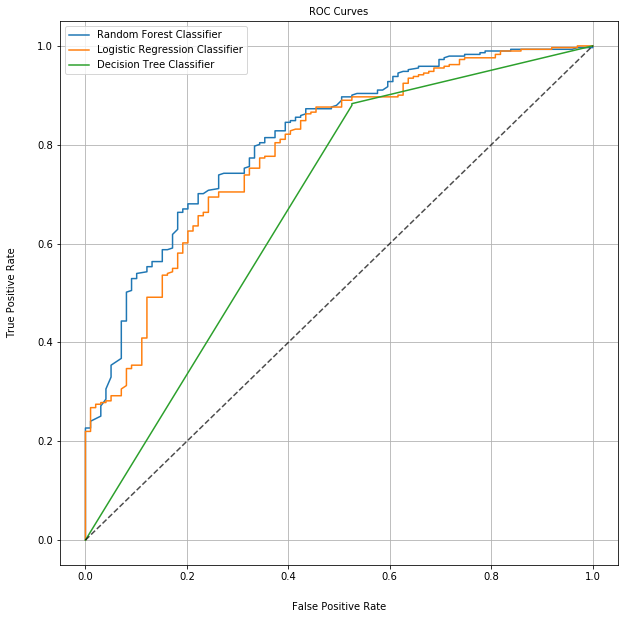

In [56]:
fig = plt.figure(figsize=(10, 10))
plt.plot(*roc_curve(y_test, rf_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, lr_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, dt_prob[:, 1])[:2])
plt.legend(["Random Forest Classifier", "Logistic Regression Classifier",
            "Decision Tree Classifier"], loc="upper left")
plt.plot((0., 1.), (0., 1.), "--k", alpha=.7) 
plt.xlabel("False Positive Rate", labelpad=20)
plt.ylabel("True Positive Rate", labelpad=20)
plt.title("ROC Curves", fontsize=10)
plt.grid()
plt.show()

In [57]:
# Taking a look at the RFC performance 
classes = ["Dead", "Alive"]
print("Random Forest Classifier Performance")
print("=" * 37)
print(classification_report(y_test, rf_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, rf_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, rf_prob[:, 1])))

Random Forest Classifier Performance
              precision    recall  f1-score   support

        Dead       0.68      0.39      0.50        99
       Alive       0.82      0.94      0.88       291

    accuracy                           0.80       390
   macro avg       0.75      0.67      0.69       390
weighted avg       0.79      0.80      0.78       390

Accuracy: 0.80
AUC score: 0.81


In [58]:
# Factorize our categorical features
df1.loc[:, "title"] = pd.factorize(df1["title"])[0]
df1.loc[:, "culture"] = pd.factorize(df1["culture"])[0]
df1.loc[:, "mother"] = pd.factorize(df1["mother"])[0]
df1.loc[:, "father"] = pd.factorize(df1["father"])[0]
df1.loc[:, "heir"] = pd.factorize(df1["heir"])[0]
df1.loc[:, "house"] = pd.factorize(df1["house"])[0]
df1.loc[:, "spouse"] = pd.factorize(df1["spouse"])[0]

In [59]:
# Split data from labels
x_fi = df1.iloc[:,1:].values
y_fi = df1.iloc[:, 0].values

df1.drop(["actual"], inplace=True, axis=1)

In [60]:
rfc = RandomForestClassifier(n_estimators=400, random_state=42)
# fitting the model from df1
rfc.fit(x_fi,y_fi);

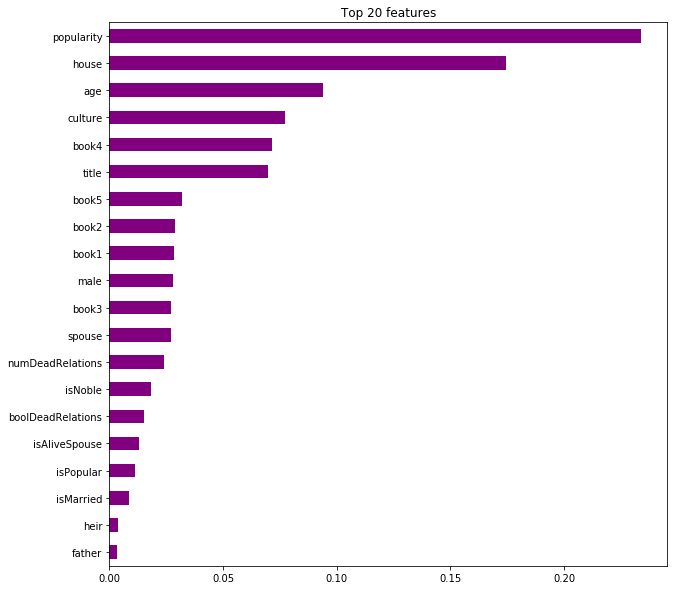

In [61]:
rf = pipeline1.named_steps['randomforestclassifier']
importances = pd.Series(rfc.feature_importances_, 
                        df1.columns)
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='purple');                         

In [62]:
# Arranging permutation impoetance
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    rfc,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(x_fi,y_fi);

In [63]:
# Visualizing the weight of features
eli5.show_weights(
    permuter,
    top=None,
    feature_names=df1.columns.tolist()
)

Weight,Feature
0.1483 ± 0.0130,popularity
0.1342 ± 0.0119,book4
0.0746 ± 0.0073,house
0.0534 ± 0.0036,book2
0.0509 ± 0.0099,book5
0.0448 ± 0.0069,male
0.0414 ± 0.0055,culture
0.0388 ± 0.0049,book1
0.0330 ± 0.0049,book3
0.0312 ± 0.0033,age
